In [79]:
import pickle

import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import shap
import xgboost as xgb

from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    auc, 
    precision_recall_curve, 
    average_precision_score, 
    classification_report, 
    confusion_matrix
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer


In [ ]:
# Function to create target variable
def create_target(df):

    # Create target variable
    df['default'] = (df.amount_outstanding_21d > 0).astype(int)

    return df

In [ ]:
def add_merchant_features(df):

    """ Add numerical merchant features, drop categorical features """

    # Average Loans
    df['merchant_category_avg_loan'] = df.groupby('merchant_category')['loan_amount'].transform('mean')
    df['merchant_group_avg_loan'] = df.groupby('merchant_group')['loan_amount'].transform('mean')

    # Average default rates
    df['merchant_category_default_rate'] = df.groupby('merchant_category')['default'].transform('mean')
    df['merchant_group_default_rate'] = df.groupby('merchant_group')['default'].transform('mean')

    df = df.drop(columns=['merchant_category', 'merchant_group'])

    return df


In [ ]:
def add_important_features(df):

     # Loan_to_debt_ratio
    df['loan_to_debt_ratio'] = df['loan_amount'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_7d_to_debt
    df['new_exposure_7d_to_debt'] = df['new_exposure_7d'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_14d_to_debt
    df['new_exposure_14d_to_debt'] = df['new_exposure_14d'] / (df['existing_klarna_debt'] + df['loan_amount'])


    # Repayment to total debt
    df['repayment_1y_to_debt'] = (df['amount_repaid_1y'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_6m_to_debt'] = (df['amount_repaid_6m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_3m_to_debt'] = (df['amount_repaid_3m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_1m_to_debt'] = (df['amount_repaid_1m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_14d_to_debt'] = (df['amount_repaid_14d'] / (df['existing_klarna_debt'] + df['loan_amount']))


    # Repayment_rate variations
    epsilon = 1e-5  # Small constant

  
    # Ratio of confirmed payments to active loans
    df['num_conf_payments_6m_to_num_loans'] = df['num_confirmed_payments_6m'] / (df['num_active_loans'] + epsilon)


    return df


In [ ]:
def impute_missing_debt(df):
    # Create a missingness flag for existing_klarna_debt
    df['existing_debt_missing'] = df['existing_klarna_debt'].isnull().astype(int)

    # Replace missing values for existing_klarna_debt with 0
    df['existing_klarna_debt'] = df['existing_klarna_debt'].fillna(0)

    # Create a missingness flag for card expiry date
    df['card_expiry_missing'] = df['card_expiry_month'].isnull().astype(int)

    return df

In [ ]:
# Function to create card expiration date
def calculate_months_to_card_expiration(df):

    """
    Calculate card_expiry_date and months_to_card_expiration between loan_issue_date and card_expiry_date.
    """
    
    # Ensure loan_issue_date is datetime
    df['loan_issue_date'] = pd.to_datetime(df['loan_issue_date'], errors='coerce')

    # Combine year and month for card expiration
    df['card_expiry_date'] = pd.to_datetime(
        df.apply(
            lambda row: f"{int(row['card_expiry_year'])}-{int(row['card_expiry_month']):02d}-01"
            if pd.notna(row['card_expiry_year']) and pd.notna(row['card_expiry_month'])
            else np.nan,
            axis=1
        ), 
        errors='coerce'
    )

    # Calculate the difference in months
    df['months_to_card_expiration'] = np.where(
        df['card_expiry_date'].notna() & df['loan_issue_date'].notna(),
        (df['card_expiry_date'].dt.year - df['loan_issue_date'].dt.year) * 12 +
        (df['card_expiry_date'].dt.month - df['loan_issue_date'].dt.month),
        np.nan
    )

     # Convert month_to_card_expiration to integer
    df['months_to_card_expiration'] = df['months_to_card_expiration'].fillna(-1).astype(int).replace(-1, np.nan)

    return df


# Load and prepare data

In [80]:
# Load the data
df = pd.read_csv('data/mlcasestudy.csv')


,loan_id,loan_issue_date,loan_amount,amount_outstanding_14d,amount_outstanding_21d,card_expiry_month,card_expiry_year,existing_klarna_debt,num_active_loans,days_since_first_loan,...,num_failed_payments_3m,num_failed_payments_6m,num_failed_payments_1y,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y,merchant_group,merchant_category
0,a55cf3062bd45a83766096fd0c4697d6,2023-06-24,5300,0,0,2.0,2026.0,21098.0,2,717,...,0,0,0,6875,15580,42325,67878,152193,Clothing & Shoes,Adult Shoes & Clothing
1,45e3d15cb313d767470722e952e14313,2023-09-22,9547,7161,7161,6.0,2027.0,NaN,0,-1,...,0,0,0,0,0,0,0,0,"Leisure, Sport & Hobby",Concept Stores & Miscellaneous
2,b195c127c7605b7b936b90bcdb5e889c,2023-07-03,5948,0,0,12.0,2023.0,NaN,0,-1,...,0,0,0,0,0,0,0,0,Clothing & Shoes,General Shoes & Clothing
3,36028b1dbeb4aeef565a79ca9700667a,2023-08-19,15871,11904,0,2.0,2026.0,31742.0,1,0,...,0,0,0,0,0,0,0,0,Clothing & Shoes,Youthful Shoes & Clothing
4,5317f8e22a8f790b6e11a0f12320422d,2023-09-30,19510,0,0,8.0,2026.0,9064.0,1,501,...,0,0,0,6511,14000,32289,61993,116532,"Leisure, Sport & Hobby",Sports Gear & Outdoor


In [85]:
# Splitting the data into train, validation and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [86]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)


In [87]:
# Apply the processing functions to the data

# create target variable
df_train = create_target(df_train)
df_val = create_target(df_val)
df_test = create_target(df_test)
df_full_train = create_target(df_full_train)

# add merchant features
df_train = add_merchant_features(df_train)
df_val = add_merchant_features(df_val)
df_test = add_merchant_features(df_test)
df_full_train = add_merchant_features(df_full_train)

# add features
df_train = add_important_features(df_train)
df_val = add_important_features(df_val)
df_test = add_important_features(df_test)
df_full_train = add_important_features(df_full_train)

# impute missing debt values and create flags
df_train = impute_missing_debt(df_train)
df_val = impute_missing_debt(df_val)
df_test = impute_missing_debt(df_test)
df_full_train = impute_missing_debt(df_full_train)


# add months to card expiration column
df_train = calculate_months_to_card_expiration(df_train)
df_val = calculate_months_to_card_expiration(df_val)
df_test = calculate_months_to_card_expiration(df_test)
df_full_train = calculate_months_to_card_expiration(df_full_train)




Prepare feature list

In [88]:
# Define helper columns
helper_columns = ['amount_outstanding_14d', 'amount_outstanding_21d', 
                  'card_expiry_month', 'card_expiry_year','card_expiry_date', 'loan_id', 'loan_issue_date']

# Extract categorical and numerical columns
categorical_features_eda = df_train.select_dtypes(include='object').columns.difference(helper_columns).tolist()
numerical_features_eda = df_train.select_dtypes(exclude='object').columns.difference(helper_columns + ['default']).tolist()


# Print categorical features 
print("\nCategorical features to explore:\n")
print("\n".join(categorical_features_eda))

# Print numerical features 
print("\nNumerical features to explore:\n")
print("\n".join(numerical_features_eda))




Categorical features to explore:



Numerical features to explore:

amount_repaid_14d
amount_repaid_1m
amount_repaid_1y
amount_repaid_3m
amount_repaid_6m
card_expiry_missing
days_since_first_loan
existing_debt_missing
existing_klarna_debt
loan_amount
loan_to_debt_ratio
merchant_category_avg_loan
merchant_category_default_rate
merchant_group_avg_loan
merchant_group_default_rate
months_to_card_expiration
new_exposure_14d
new_exposure_14d_to_debt
new_exposure_7d
new_exposure_7d_to_debt
num_active_loans
num_conf_payments_6m_to_num_loans
num_confirmed_payments_3m
num_confirmed_payments_6m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m
repayment_14d_to_debt
repayment_1m_to_debt
repayment_1y_to_debt
repayment_3m_to_debt
repayment_6m_to_debt


# Feature selection

Feature selection - identify highly correlated features and drop to avoid multicollinearity. 

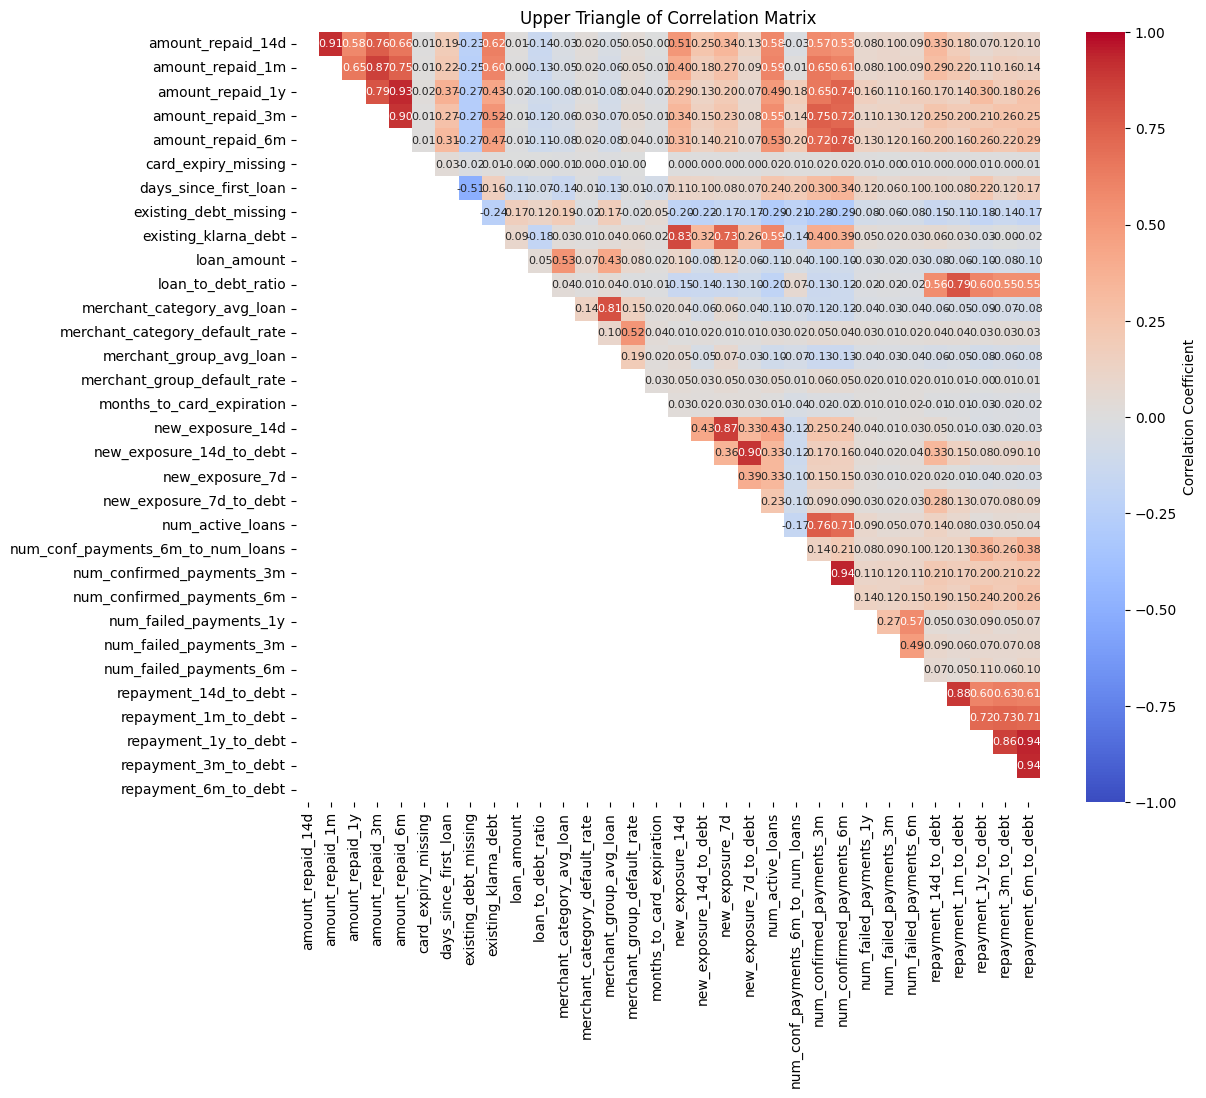

In [93]:
# Compute the correlation matrix
corr_matrix = df_train[numerical_features_eda].corr()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))


In [94]:

# Set the correlation threshold
threshold = 0.95

# Find index of features with correlation greater than the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

print(f'There are {len(to_drop)} columns to remove:')
print(to_drop)

There are 0 columns to remove:
[]


Finalize list of features

In [95]:
# Remove from the list of features as needed
numerical_features = [
    feature for feature in numerical_features_eda 
    if feature not in to_drop 
    #and feature not in helper_columns
]

# Remove from the list of features as needed
categorical_features = categorical_features_eda 


# Print numerical features as a vertical list
print("\nNumerical features to use in training:\n")
print("\n".join(numerical_features))

# Print categorical features as a vertical list
print("\nCategorical features to use in training:\n")
print("\n".join(categorical_features))




Numerical features to use in training:

amount_repaid_14d
amount_repaid_1m
amount_repaid_1y
amount_repaid_3m
amount_repaid_6m
card_expiry_missing
days_since_first_loan
existing_debt_missing
existing_klarna_debt
loan_amount
loan_to_debt_ratio
merchant_category_avg_loan
merchant_category_default_rate
merchant_group_avg_loan
merchant_group_default_rate
months_to_card_expiration
new_exposure_14d
new_exposure_14d_to_debt
new_exposure_7d
new_exposure_7d_to_debt
num_active_loans
num_conf_payments_6m_to_num_loans
num_confirmed_payments_3m
num_confirmed_payments_6m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m
repayment_14d_to_debt
repayment_1m_to_debt
repayment_1y_to_debt
repayment_3m_to_debt
repayment_6m_to_debt

Categorical features to use in training:




In [96]:
numerical_features

['amount_repaid_14d',
 'amount_repaid_1m',
 'amount_repaid_1y',
 'amount_repaid_3m',
 'amount_repaid_6m',
 'card_expiry_missing',
 'days_since_first_loan',
 'existing_debt_missing',
 'existing_klarna_debt',
 'loan_amount',
 'loan_to_debt_ratio',
 'merchant_category_avg_loan',
 'merchant_category_default_rate',
 'merchant_group_avg_loan',
 'merchant_group_default_rate',
 'months_to_card_expiration',
 'new_exposure_14d',
 'new_exposure_14d_to_debt',
 'new_exposure_7d',
 'new_exposure_7d_to_debt',
 'num_active_loans',
 'num_conf_payments_6m_to_num_loans',
 'num_confirmed_payments_3m',
 'num_confirmed_payments_6m',
 'num_failed_payments_1y',
 'num_failed_payments_3m',
 'num_failed_payments_6m',
 'repayment_14d_to_debt',
 'repayment_1m_to_debt',
 'repayment_1y_to_debt',
 'repayment_3m_to_debt',
 'repayment_6m_to_debt']

In [97]:

# Assert that 'default' is not in numerical_features
assert 'default' not in numerical_features, "'default' is still in numerical_features!"


In [98]:
# Get all columns in df_train
all_columns = set(df_train.columns)

# Combine numerical_features and categorical_features
selected_features = set(numerical_features + categorical_features)

# Find columns that are not in either list
not_in_training = all_columns - selected_features

# Print the result
print("\nColumns not included in training:\n")
print("\n".join(sorted(not_in_training)))




Columns not included in training:

amount_outstanding_14d
amount_outstanding_21d
card_expiry_date
card_expiry_month
card_expiry_year
default
loan_id
loan_issue_date


# Preprocessing pipeline

Define the steps to prepare data for training and evaluation

In [99]:
# Create transformations for each type of features

# Numerical features - no processing
numerical_transformer = 'passthrough'

# Categorical features - one-hot encoding ignoring unknown categories
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [100]:
# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [101]:
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

Apply preprocessing

In [102]:
# Transform training data
X_train_transformed = preprocessing_pipeline.fit_transform(df_train[numerical_features + categorical_features])
y_train = df_train['default'].values

# Transform validation data
X_val_transformed = preprocessing_pipeline.transform(df_val[numerical_features + categorical_features])
y_val = df_val['default'].values

In [103]:
# Get feature names from the preprocessing pipeline
numerical_features_transformed = numerical_features 


# Combine numerical and transformed categorical feature names
all_feature_names = list(numerical_features_transformed) 

In [104]:
all_feature_names

['amount_repaid_14d',
 'amount_repaid_1m',
 'amount_repaid_1y',
 'amount_repaid_3m',
 'amount_repaid_6m',
 'card_expiry_missing',
 'days_since_first_loan',
 'existing_debt_missing',
 'existing_klarna_debt',
 'loan_amount',
 'loan_to_debt_ratio',
 'merchant_category_avg_loan',
 'merchant_category_default_rate',
 'merchant_group_avg_loan',
 'merchant_group_default_rate',
 'months_to_card_expiration',
 'new_exposure_14d',
 'new_exposure_14d_to_debt',
 'new_exposure_7d',
 'new_exposure_7d_to_debt',
 'num_active_loans',
 'num_conf_payments_6m_to_num_loans',
 'num_confirmed_payments_3m',
 'num_confirmed_payments_6m',
 'num_failed_payments_1y',
 'num_failed_payments_3m',
 'num_failed_payments_6m',
 'repayment_14d_to_debt',
 'repayment_1m_to_debt',
 'repayment_1y_to_debt',
 'repayment_3m_to_debt',
 'repayment_6m_to_debt']

# Train model

In [105]:
# Initialize a dictionary to store the best models and their scores
best_models = {}

Gradient Boosted Trees

In [106]:

### XGBoost Tuning ###
pipeline_xgb = Pipeline([
    ('model', xgb.XGBClassifier(objective='binary:logistic')) 
    #nthread=8 for 8 CPU threads, the default is to automatically use the optimal number of threads
   
])

param_grid_xgb = {
    
    'model__n_estimators': [100], # number of trees
    'model__eta': [0.01, 0.1, 0.2], # contribution of each tree
    'model__max_depth': [3, 6, 9], # max number of splits
    'model__min_child_weight': [3, 5, 7], # min amount of data in leaf node
    #'model__subsample': [0.6, 0.8, 1.0], # fraction of training data used to grow trees
    #'model__colsample_bytree': [0.6, 0.8, 1.0], # fraction of features sampled for each tree
    #'model__gamma': [0, 1, 5], # min loss reduction

}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, scoring='roc_auc', cv=4, verbose=1)
grid_search_xgb.fit(X_train_transformed, y_train)

# Store the best XGBoost model and its AUC score
best_models['XGBoost'] = {
    'model': grid_search_xgb.best_estimator_,
    'auc': grid_search_xgb.best_score_
}

print("Best XGBoost parameters:", grid_search_xgb.best_params_)
print("Best XGBoost AUC:", grid_search_xgb.best_score_)


Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best XGBoost parameters: {'model__eta': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 7, 'model__n_estimators': 100}
Best XGBoost AUC: 0.6869767669253335


# Train the best model on the full training data

### Final training data

In [107]:
df_test.columns

Index(['loan_id', 'loan_issue_date', 'loan_amount', 'amount_outstanding_14d',
       'amount_outstanding_21d', 'card_expiry_month', 'card_expiry_year',
       'existing_klarna_debt', 'num_active_loans', 'days_since_first_loan',
       'new_exposure_7d', 'new_exposure_14d', 'num_confirmed_payments_3m',
       'num_confirmed_payments_6m', 'num_failed_payments_3m',
       'num_failed_payments_6m', 'num_failed_payments_1y', 'amount_repaid_14d',
       'amount_repaid_1m', 'amount_repaid_3m', 'amount_repaid_6m',
       'amount_repaid_1y', 'default', 'existing_debt_missing',
       'card_expiry_missing', 'loan_to_debt_ratio', 'new_exposure_7d_to_debt',
       'new_exposure_14d_to_debt', 'repayment_1y_to_debt',
       'repayment_6m_to_debt', 'repayment_3m_to_debt', 'repayment_1m_to_debt',
       'repayment_14d_to_debt', 'num_conf_payments_6m_to_num_loans',
       'merchant_category_avg_loan', 'merchant_group_avg_loan',
       'merchant_category_default_rate', 'merchant_group_default_rate',
   

In [108]:
# Transform full training data
X_full_train_transformed = preprocessing_pipeline.fit_transform(df_full_train[numerical_features ])
y_full_train = df_full_train['default'].values

# Transform test data
X_test_transformed = preprocessing_pipeline.transform(df_test[numerical_features ])
y_test = df_test['default'].values


In [109]:
# Fit the best model on the full training data
best_model = best_models['XGBoost']['model']
best_model.fit(X_full_train_transformed, y_full_train)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=7,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [110]:
y_pred = best_model.predict_proba(X_test_transformed)[:, 1]

In [111]:
# AUC score on full training data - this is to check for overfitting
y_train_pred = best_model.predict_proba(X_full_train_transformed)[:, 1]
train_auc = roc_auc_score(y_full_train, y_train_pred)
print(f"Train AUC: {train_auc}")


cv_auc = cross_val_score(best_model, X_full_train_transformed, y_full_train, cv=5, scoring='roc_auc')
print(f"Cross-validated AUC on full training data: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")



Train AUC: 0.7135380238335317
Cross-validated AUC on full training data: 0.6877 ± 0.0090


In [112]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

# Baseline precision line
baseline_class_proportion = y_test.mean()


Save curves to compare with other models

In [113]:


# Create a dictionary to store the metrics
roc_pr_data = {
    'roc': {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'roc_auc': roc_auc},
    'pr': {'precision': precision.tolist(), 'recall': recall.tolist(), 'ap': ap}
}

# Save to JSON file
with open('model_spec_5_metrics.json', 'w') as f:
    json.dump(roc_pr_data, f)

print("Metrics saved to model_spec_5_metrics.json")


Metrics saved to model_spec_5_metrics.json


Load model from the previous step

In [114]:

with open('model_spec_4_metrics.json', 'r') as f:
    roc_pr_data_4 = json.load(f)

# Extract the data
fpr_4 = roc_pr_data_4['roc']['fpr']
tpr_4 = roc_pr_data_4['roc']['tpr']
roc_auc_4 = roc_pr_data_4['roc']['roc_auc']

precision_4 = roc_pr_data_4['pr']['precision']
recall_4 = roc_pr_data_4['pr']['recall']
ap_4 = roc_pr_data_4['pr']['ap']

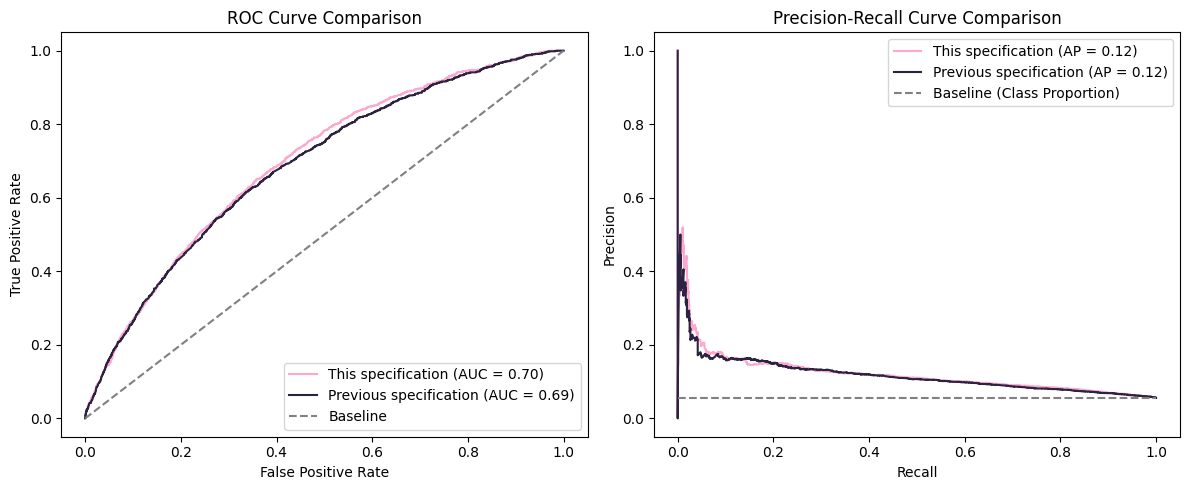

In [115]:
# Compare current model with the previous model
plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'This specification (AUC = {roc_auc:.2f})', color = '#FFA8CD')   #2C2242
plt.plot(fpr_4, tpr_4, label=f'Previous specification (AUC = {roc_auc_4:.2f})', color = '#2C2242') #FFA8CD
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'This specification (AP = {ap:.2f})', color = '#FFA8CD')
plt.plot(recall_4, precision_4, label=f'Previous specification (AP = {ap_4:.2f})', color = '#2C2242')
plt.hlines(y_test.mean(), xmin=0, xmax=1, color='grey', linestyle='--', label='Baseline (Class Proportion)')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Feature importance

In [116]:
# Verify ferature names
instance_idx = 5

feature_values = zip(all_feature_names, X_full_train_transformed[instance_idx, :])

# Display feature values in a readable format
print(f"Feature values for instance {instance_idx}:")
for feature_name, feature_value in feature_values:
    print(f"{feature_name}: {feature_value}")

Feature values for instance 5:
amount_repaid_14d: 0.0
amount_repaid_1m: 0.0
amount_repaid_1y: 3628.0
amount_repaid_3m: 0.0
amount_repaid_6m: 3628.0
card_expiry_missing: 0.0
days_since_first_loan: 170.0
existing_debt_missing: 0.0
existing_klarna_debt: 0.0
loan_amount: 4718.0
loan_to_debt_ratio: 1.0
merchant_category_avg_loan: 12198.490958976563
merchant_category_default_rate: 0.05239496215001157
merchant_group_avg_loan: 12483.338661551577
merchant_group_default_rate: 0.058455397969464466
months_to_card_expiration: 4.0
new_exposure_14d: 0.0
new_exposure_14d_to_debt: 0.0
new_exposure_7d: 0.0
new_exposure_7d_to_debt: 0.0
num_active_loans: 0.0
num_conf_payments_6m_to_num_loans: 399999.99999999994
num_confirmed_payments_3m: 0.0
num_confirmed_payments_6m: 4.0
num_failed_payments_1y: 0.0
num_failed_payments_3m: 0.0
num_failed_payments_6m: 0.0
repayment_14d_to_debt: 0.0
repayment_1m_to_debt: 0.0
repayment_1y_to_debt: 0.7689699025010598
repayment_3m_to_debt: 0.0
repayment_6m_to_debt: 0.768969902

In [117]:
df[(df.loan_amount == 4718.0) & (df.amount_repaid_1y == 3628.0)]

,loan_id,loan_issue_date,loan_amount,amount_outstanding_14d,amount_outstanding_21d,card_expiry_month,card_expiry_year,existing_klarna_debt,num_active_loans,days_since_first_loan,...,num_failed_payments_6m,num_failed_payments_1y,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y,merchant_group,merchant_category,default
53334,b6e6bf6717661225bd8f572a63bea119,2023-09-03,4718,0,0,1.0,2024.0,0.0,0,170,...,0,0,0,0,0,3628,3628,Clothing & Shoes,General Shoes & Clothing,0


In [118]:
model_object = best_model.named_steps['model']

In [119]:

# Create SHAP TreeExplainer for the tree-based model
explainer = shap.TreeExplainer(model_object)

# Calculate SHAP values
shap_values = explainer.shap_values(X_full_train_transformed)

# Wrap shap_values into an Explanation object
shap_values_with_names = shap.Explanation(
    values=shap_values,                   # SHAP values matrix
    base_values=explainer.expected_value, # Base values
    data=X_full_train_transformed,              # Transformed feature values
    feature_names=all_feature_names       # Feature names
)


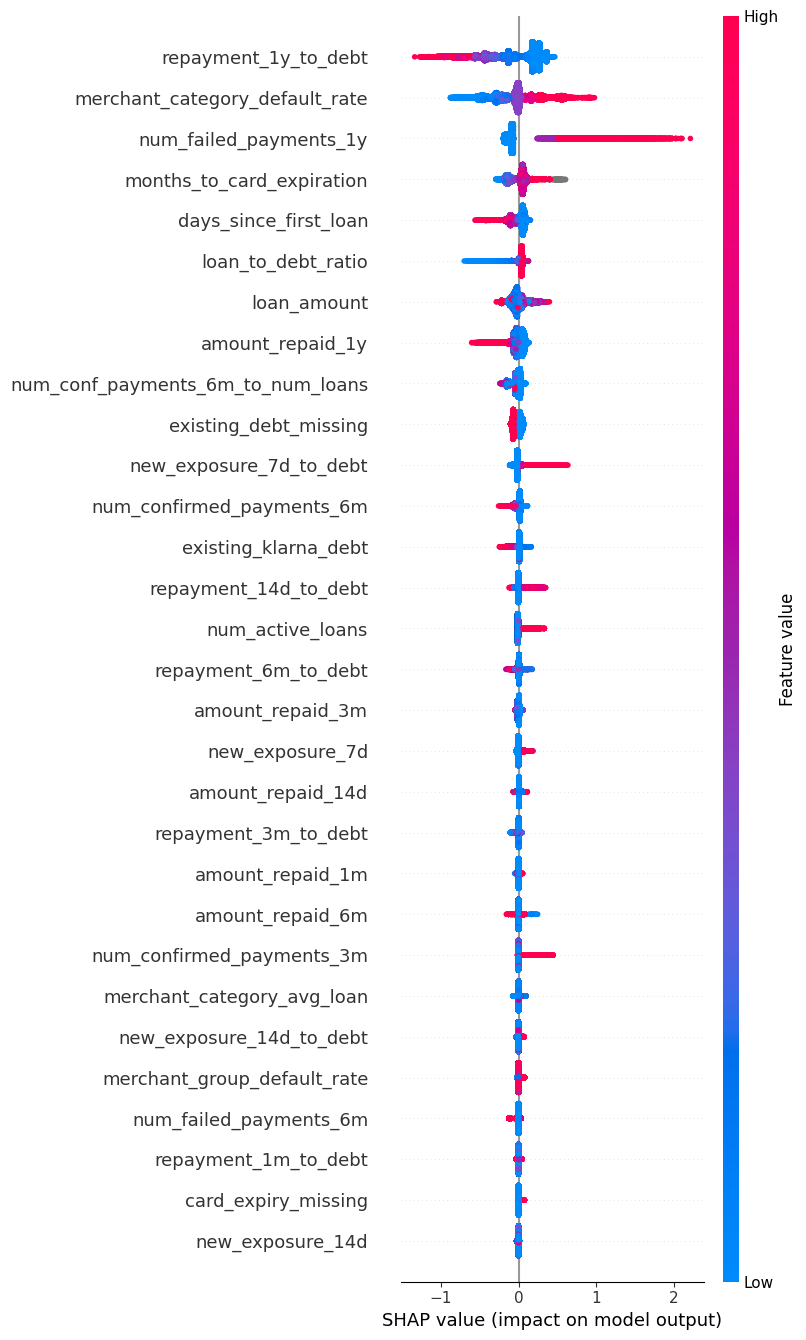

In [120]:
#  Density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output
shap.summary_plot(shap_values_with_names, X_full_train_transformed, max_display = 30)

Conclusion: merchant-level numerical variables contribute to model's predictions

# COPY THIS INTO STEP 4

## ADJUST TUNING

Tune subsample, colsample and gamma

In [122]:

pipeline_xgb_step2 = Pipeline([
    ('model', xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators = 100,
        eta = 0.1,
        max_depth = 3,
        min_child_weight = 7)
     )
]
)

param_grid_xgb_step2 = {

    'model__subsample': [0.6, 0.8, 1.0], # fraction of training data used to grow trees
    'model__colsample_bytree': [0.6, 0.8, 1.0], # fraction of features sampled for each tree
    'model__gamma': [0, 1, 5], # min loss reduction
}


grid_search_xgb_step2 = GridSearchCV(pipeline_xgb_step2, param_grid_xgb_step2, scoring='roc_auc', cv=4, verbose=1)
grid_search_xgb_step2.fit(X_train_transformed, y_train)

# Store the best XGBoost model and its AUC score
best_models['XGBoost'] = {
    'model': grid_search_xgb_step2.best_estimator_,
    'auc': grid_search_xgb_step2.best_score_
}

print("Best XGBoost parameters:", grid_search_xgb_step2.best_params_)
print("Best XGBoost AUC:", grid_search_xgb_step2.best_score_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
Best XGBoost parameters: {'model__colsample_bytree': 0.8, 'model__gamma': 1, 'model__subsample': 0.8}
Best XGBoost AUC: 0.6870090880028651


Tune scale_pos_weight

In [123]:
num_positive = sum(y_train==1)
num_negative = sum(y_train==0)
pos_ratio = num_negative/num_positive

In [124]:
pos_ratio

np.float64(17.712374581939798)

In [125]:
pipeline_xgb_step3 = Pipeline([
    ('model', xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators = 100,
        eta = 0.1,
        max_depth = 3,
        min_child_weight = 7,
        subsample = 1.0,
        colsample_bytree = 1.0,
        gamma = 1)
     )
]
)

param_grid_xgb_step3 = {
    'model__scale_pos_weight': [pos_ratio*0.5, pos_ratio, pos_ratio*1.5, pos_ratio*2] # balance positive and negative weights
}

grid_search_xgb_step3 = GridSearchCV(pipeline_xgb_step3, param_grid_xgb_step3, scoring='roc_auc', cv=4, verbose=1)
grid_search_xgb_step3.fit(X_train_transformed, y_train)

# Store the best XGBoost model and its AUC score
best_models['XGBoost'] = {
    'model': grid_search_xgb_step3.best_estimator_,
    'auc': grid_search_xgb_step3.best_score_
}

print("Best XGBoost parameters:", grid_search_xgb_step3.best_params_)
print("Best XGBoost AUC:", grid_search_xgb_step3.best_score_)


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best XGBoost parameters: {'model__scale_pos_weight': np.float64(8.856187290969899)}
Best XGBoost AUC: 0.6851171252698656


In [126]:
grid_search_xgb_step3.best_estimator_

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=1,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=7,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [147]:
#y_pred = grid_search_xgb_step2.best_estimator_.predict_proba(X_test_transformed)[:, 1]
y_pred = grid_search_xgb_step3.best_estimator_.predict_proba(X_test_transformed)[:, 1]

In [148]:
# Final AUC score on test data
auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc}")

Test AUC: 0.6917522534494668


SHAP?

## Calibration Performance

* Above the diagonal: Fraction of Positives is higher than we predict, i.e. this is where True Negatives are (cost of default)
* Below the diagonal: Fraction of true positive is lower than we predict, i.e. this is where False Negatives are (lost profit) 

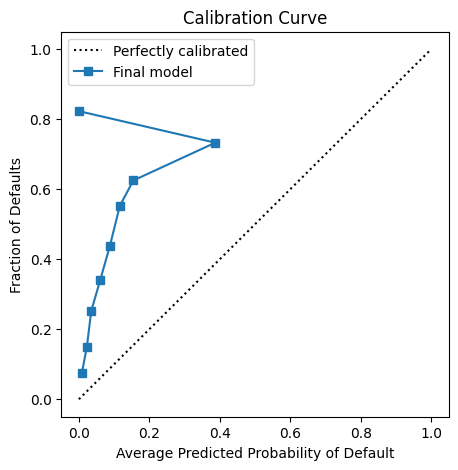

In [146]:
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(prob_true, prob_pred, 's-', label='Final model')
plt.ylabel('Fraction of Defaults')
plt.xlabel('Average Predicted Probability of Default')
plt.legend()
plt.title('Calibration Curve')
plt.show()